# Matthew's Data Manipulation and Analysis

In this Notebook I will be taking a look at the data from the "IMDB" and "The Numbers" databases. Based on my findings, I will produce a recommendation that is relevant for the client.

**Which genre(s) give the most lift to profit? ROI? Profit margin?**

I will clean, investigate, and visualize data in relation to this question.

In [241]:
# Import relevant Python packages.
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [196]:
# Open and save data from "IMDB" and "The Numbers" csv files,
imdb = pd.read_csv("../Data/imdb_data")
tn = pd.read_csv("../Data/tn_data")

In [197]:
# Visually confirm IMDB data loaded as expected
imdb.head()

,movie_id,primary_title,runtime_minutes,genres,averagerating,numvotes
0,sunghursh2013,Sunghursh,175.0,"Action,Crime,Drama",7.0,77.0
1,one day before the rainy season2019,One Day Before the Rainy Season,114.0,"Biography,Drama",7.2,43.0
2,the other side of the wind2018,The Other Side of the Wind,122.0,Drama,6.9,4517.0
3,sabse bada sukh2018,Sabse Bada Sukh,NaN,"Comedy,Drama",6.1,13.0
4,the wandering soap opera2017,The Wandering Soap Opera,80.0,"Comedy,Drama,Fantasy",6.5,119.0


In [198]:
# Visually confirm TN data loaded as expected
tn.head()

,movie_id,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total profit,ROI,domestic profit,domestic profit margin,total profit margin
0,avatar2009,1,2009-12-18,Avatar,425000000,760507625,2776345279,2351345279,5.532577,335507625,0.441163,0.846921
1,pirates of the caribbean: on stranger tides2011,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,635063875,1.546673,-169536125,-0.703283,0.607331
2,dark phoenix2019,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,-200237650,-0.572108,-307237650,-7.184770,-1.337036
3,avengers: age of ultron2015,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,1072413963,3.243841,128405868,0.279748,0.764364
4,star wars ep. viii: the last jedi2017,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,999721747,3.153696,303181382,0.488859,0.759251


## Data Preperation

### IMDB
The data requires a bit more cleaning before we begin.

In [199]:
# Our group decided to drop the IMDB rows where the 'numvotes' column = 0/NaN as these entries are usually an error
imdb.dropna(subset=['numvotes'], inplace=True)


In [200]:
# Confirm rows were dropped by checking how many rows there are.
imdb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73856 entries, 0 to 146134
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   runtime_minutes  66236 non-null  float64
 3   genres           73052 non-null  object 
 4   averagerating    73856 non-null  float64
 5   numvotes         73856 non-null  float64
dtypes: float64(3), object(3)
memory usage: 3.9+ MB


In [201]:
# Remove the duplicate values in 'movie_id' and keep the entry with the most votes
imdb = imdb.sort_values('numvotes', ascending=False).drop_duplicates(subset='movie_id')
#I sorted the table by 'numvotes', descending, and then kept the first occurance of an entry.

# Confirming duplicated were deleted.
imdb.duplicated('movie_id').value_counts()

False    73264
dtype: int64

In [202]:
# For the objective, I need to turn the 'genres' column into something more uniform
# Split the genre column
imdb['genres'] = imdb['genres'].str.split(',')

# explode the genres column into rows for each genre
imdb = imdb.explode('genres')
#visually confirm expected results
imdb.head()

,movie_id,primary_title,runtime_minutes,genres,averagerating,numvotes
7066,inception2010,Inception,148.0,Action,8.8,1841066.0
7066,inception2010,Inception,148.0,Adventure,8.8,1841066.0
7066,inception2010,Inception,148.0,Sci-Fi,8.8,1841066.0
6900,the dark knight rises2012,The Dark Knight Rises,164.0,Action,8.4,1387769.0
6900,the dark knight rises2012,The Dark Knight Rises,164.0,Thriller,8.4,1387769.0


### The Numbers

In [203]:
# Check for duplicates
tn[tn.duplicated(subset=['movie_id'], keep=False)]

,movie_id,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total profit,ROI,domestic profit,domestic profit margin,total profit margin
3455,home2009,56,2009-06-05,Home,12000000,0,0,-12000000,-1.000000,-12000000,-inf,-inf
5459,home2009,60,2009-04-23,Home,500000,15433,44793168,44293168,88.586336,-484567,-31.398108,0.988838


It is two different movies with the same name, it would be normally fine to keep both of them, but because one has a "worldwide_gross" of 0 we will be removing it anyway.

In [204]:
# My group agreed to remove any row with a 'worldwide_gross' of 0 since it is probably a placeholder value.
tn['worldwide_gross'].value_counts().head(1)

0    367
Name: worldwide_gross, dtype: int64

In [205]:
# Remove "worldwide_gross" rows that are 0
tn.drop(tn[tn['worldwide_gross'] == 0].index, inplace=True)

In [206]:
# Visually confirm expected results
tn[tn['worldwide_gross'] == 0]

,movie_id,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total profit,ROI,domestic profit,domestic profit margin,total profit margin


### Join Tables

In [207]:
# Merge tables on "move_id" column
imdb_tn = imdb.merge(tn, on='movie_id')

# Visually confirm expected results
imdb_tn.head()

,movie_id,primary_title,runtime_minutes,genres,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,total profit,ROI,domestic profit,domestic profit margin,total profit margin
0,inception2010,Inception,148.0,Action,8.8,1841066.0,38,2010-07-16,Inception,160000000,292576195,835524642,675524642,4.222029,132576195,0.453134,0.808504
1,inception2010,Inception,148.0,Adventure,8.8,1841066.0,38,2010-07-16,Inception,160000000,292576195,835524642,675524642,4.222029,132576195,0.453134,0.808504
2,inception2010,Inception,148.0,Sci-Fi,8.8,1841066.0,38,2010-07-16,Inception,160000000,292576195,835524642,675524642,4.222029,132576195,0.453134,0.808504
3,the dark knight rises2012,The Dark Knight Rises,164.0,Action,8.4,1387769.0,11,2012-07-20,The Dark Knight Rises,275000000,448139099,1084439099,809439099,2.943415,173139099,0.386351,0.746413
4,the dark knight rises2012,The Dark Knight Rises,164.0,Thriller,8.4,1387769.0,11,2012-07-20,The Dark Knight Rises,275000000,448139099,1084439099,809439099,2.943415,173139099,0.386351,0.746413


In [208]:
# Group the table by generes, and aggregate by the median. Sort by "worldwide_gross", descending
grouped_imdb_tn = imdb_tn.groupby('genres').median().sort_values('ROI', ascending=False)

# Visually confirm expected results
grouped_imdb_tn

,runtime_minutes,averagerating,numvotes,id,production_budget,domestic_gross,worldwide_gross,total profit,ROI,domestic profit,domestic profit margin,total profit margin
genres,,,,,,,,,,,,
Mystery,105.0,6.30,68998.0,55.0,14500000.0,26851266.5,61166295.5,39117893.5,2.573175,5842441.0,0.373493,0.719501
Horror,95.5,5.90,47808.5,55.0,10000000.0,26197915.5,44202303.5,29065832.0,2.296345,5946759.5,0.211461,0.696634
Animation,95.0,6.70,73170.5,43.5,87500000.0,113370261.5,316450194.5,202467009.0,1.996890,19525370.0,0.129395,0.666321
Sci-Fi,112.0,6.60,204481.0,50.0,90000000.0,78765986.0,240647629.0,123617305.0,1.778310,2853933.0,0.092566,0.640069
Adventure,108.0,6.50,123127.0,46.0,100000000.0,83670083.0,249517956.0,133691277.0,1.659514,-2464983.0,-0.059707,0.623991
Thriller,105.0,6.30,78932.5,54.5,21000000.0,30570973.5,57176634.0,35944700.5,1.534840,1052201.0,0.035539,0.605495
Comedy,102.0,6.30,59253.0,50.0,29000000.0,40847995.0,70027933.0,35768579.0,1.494504,4669521.0,0.193255,0.599119
Romance,105.0,6.30,55698.0,58.0,18000000.0,24477704.0,42843521.0,19795070.0,1.369697,2915773.0,0.196744,0.578005
Music,107.0,6.40,22977.0,58.0,15000000.0,20218921.0,32700439.0,12876066.0,1.287002,3432113.0,0.258121,0.562746


My group decided we would use median as a measure of central tendency, as there are extreme outlier that were affecting the means of this value.  


## Visualizations

From here I will be making 3 graphs:

- A graph of the median ROI value by movie genre
- A graph showing the 90th percentile values by movie genre
- A graph showing the 10th percentile value by movie genre.

These visuals will assist in informing and communicating our final recommendation.

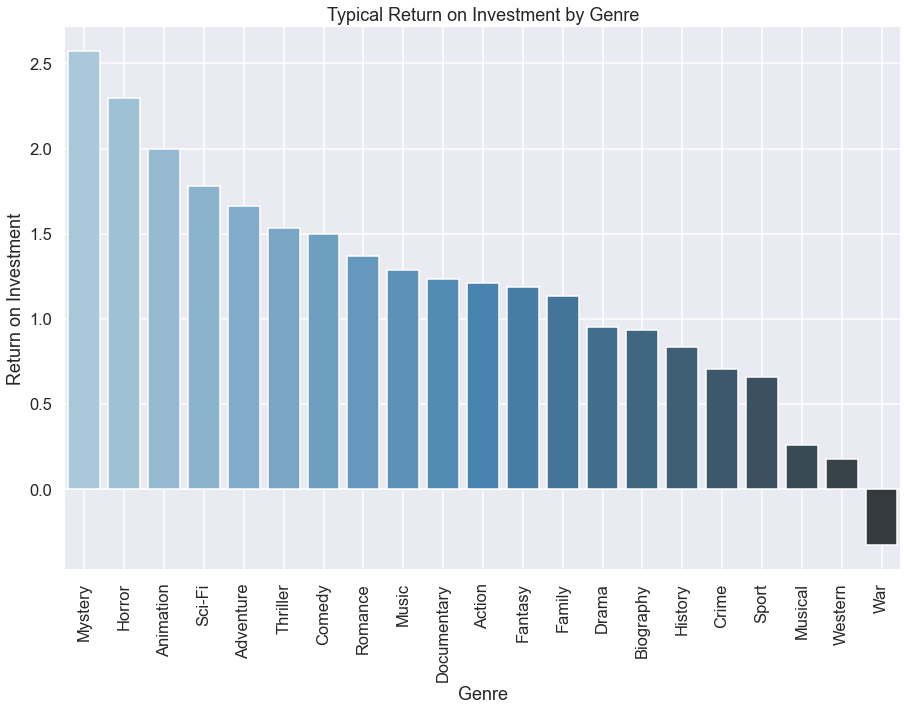

In [283]:
# Define figure/axis
fig, ax = plt.subplots() 

# Set Seaborn figure size and style
sns.set(rc={'figure.figsize':(15,10)})
sns.set_theme(context='talk')

# Create visual
imdb_tn_meidan = sns.barplot(data=grouped_imdb_tn, x=grouped_imdb_tn.index, y='ROI', ax=ax, palette="Blues_d" )

# Customize asthetic
imdb_tn_meidan.set_xticklabels(imdb_tn_meidan.get_xticklabels(),rotation = 90) # rotate xaxis tick labels
ax.xaxis.grid(True) # Show the vertical gridlines
imdb_tn_meidan.set_title('Typical Return on Investment by Genre')
imdb_tn_meidan.set_xlabel('Genre')
imdb_tn_meidan.set_ylabel('Return on Investment');

Just from this graph it is easy to see that some 